In [1]:
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.multiclass
import sklearn.neighbors
import sklearn.ensemble
import sklearn.datasets
import sklearn.base
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

np.random.seed(42)

## 3.1 MNIST
We will be using the MNIST dataset, which is a set of 70,000 small images. Each image is labeled with the digit it represents. This set is often called the “Hello World” of Machine Learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST.

Scikit-Learn provides helper function to download the MNIST dataset:

In [2]:
mnist = sklearn.datasets.fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 to 255. Let’s take a peek at one digit from the dataset:

Label =  5.0


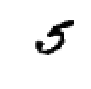

In [4]:
some_digit = X[36000] 
some_digit_image = some_digit.reshape(28, 28)
print("Label = ", y[36000])

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest") 
plt.gcf().set_size_inches(1, 1)
plt.axis("off")
plt.show()

`Figure 3-1` shows a few more images from the MNIST dataset to give you a feel for the complexity of the classification task:
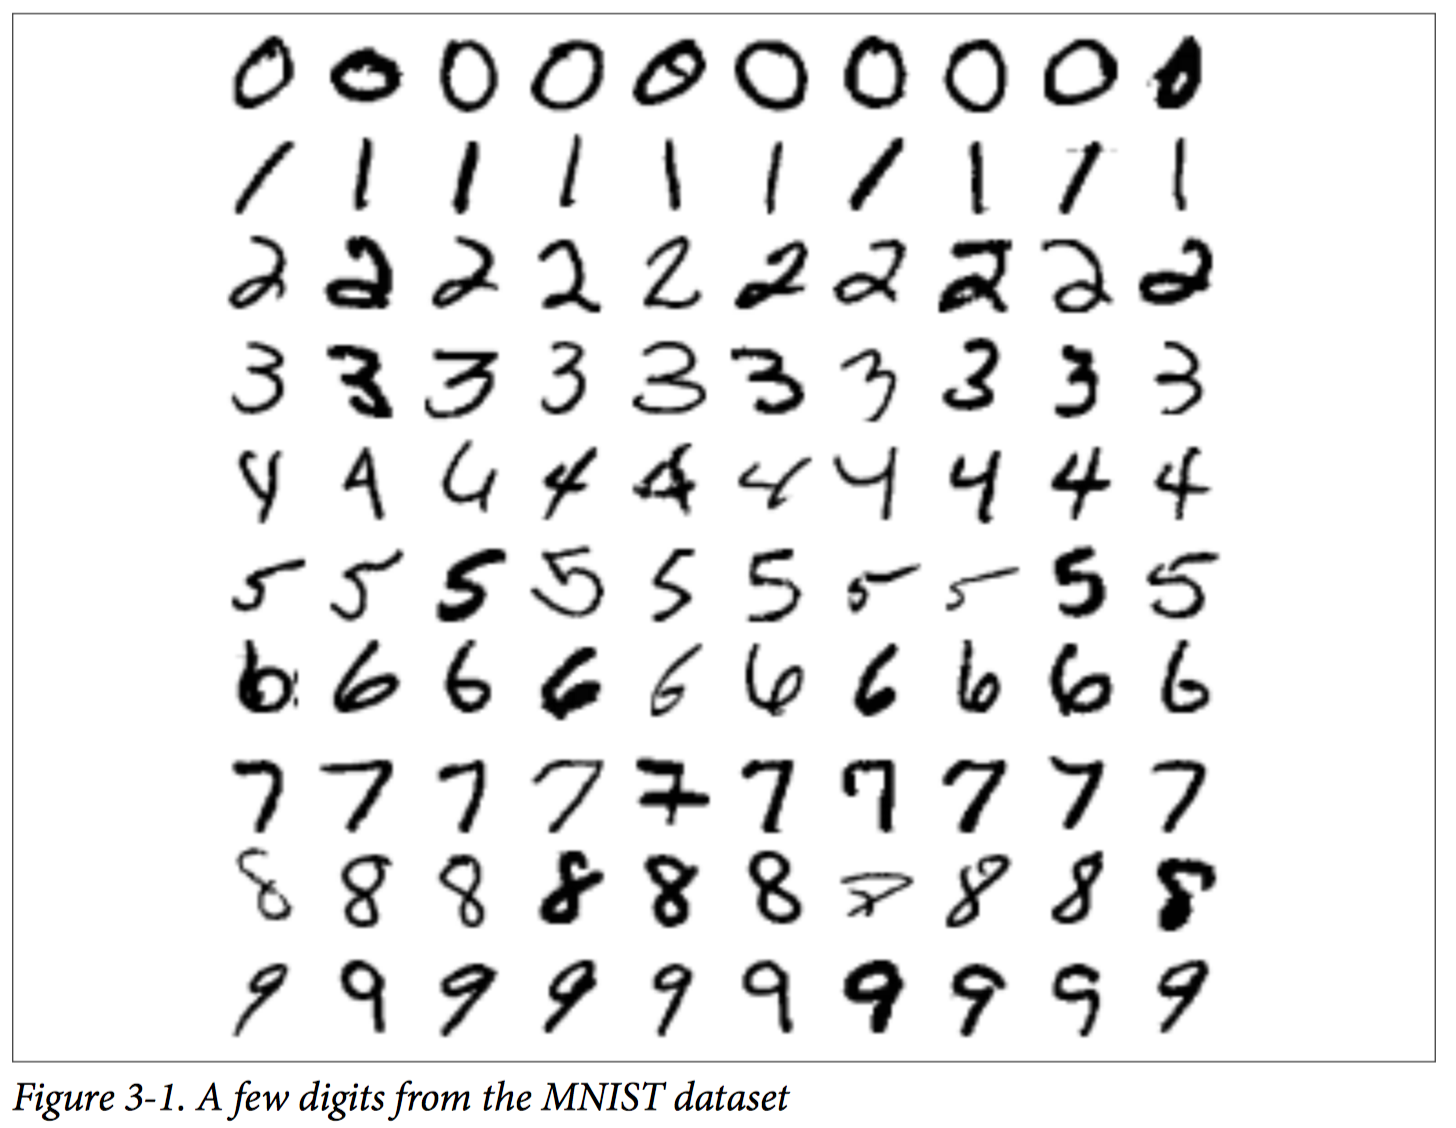

The MNIST dataset is already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen:

In [6]:
shuffle_index = np.random.permutation(60000) 
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
y_train

array([ 1.,  6.,  6., ...,  0.,  2.,  9.])

> Shuffling may be a bad idea in some contexts. For example, if you are working on time series data (such as stock market prices or weather conditions). We will explore this in the next chapters.

## 3.2 Training a Binary Classifier
Let’s simplify the problem for now and only try to identify `5`. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, `5` and `not-5`. Let’s create the target vectors for this classification task:

In [7]:
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)
y_train_5, y_test_5

(array([False, False, False, ..., False, False, False], dtype=bool),
 array([False, False, False, ..., False, False, False], dtype=bool))

Let’s pick a classifier and train it. A good place to start is with a `Stochastic Gradient Descent` (SGD) classifier, using Scikit-Learn’s `SGDClassifier` class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later. Let’s create an `SGDClassifier` and train it on the whole training set:

In [8]:
# SGDClassifier relies on randomness during training (hence the name “stochastic”)
# If you want reproducible results, you should set the random_state parameter
sgd_clf = sklearn.linear_model.SGDClassifier(random_state=42, max_iter=5)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## 3.3 Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available.

### 3.3.1 Measuring Accuracy Using Cross-Validation
Let’s use the `cross_val_score()` function to evaluate your `SGDClassifier` model using K-fold cross-validation, with 3 folds:

In [9]:
sklearn.model_selection.cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9502 ,  0.96565,  0.96495])

Wow! Above $95\%$ accuracy on all cross-validation folds? This looks amazing! Well, before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [10]:
class Never5Classifier(sklearn.base.BaseEstimator):
    def fit(self, X, y=None):
        pass 
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
sklearn.model_selection.cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.909  ,  0.90715,  0.9128 ])

It has over $90\%$ accuracy! This is simply because only about $10\%$ of the images are `5`, so if you always guess that an image is `not-5`, you will be right about $90\%$ of the time.

***This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets***.


### 3.3.2 Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the `confusion matrix`. The general idea is to count the number of times instances of class A are classified as class B.

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now. Instead, you can use the `cross_val_predict()` function:

In [11]:
y_train_pred = sklearn.model_selection.cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred.shape

(60000,)

Just like the `cross_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the `confusion_matrix()` function:

In [12]:
sklearn.metrics.confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [13]:
y_train_perfect_predictions = y_train_5
sklearn.metrics.confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the `precision`:
- $precision = \frac{TP}{TP+FP}$

So precision is typically used along with another metric named `recall`, also called `true positive rate` (TPR): 
- $recall = \frac{TP}{TP+FN}$

If you are confused about the confusion matrix, `Figure 3-2` may help:
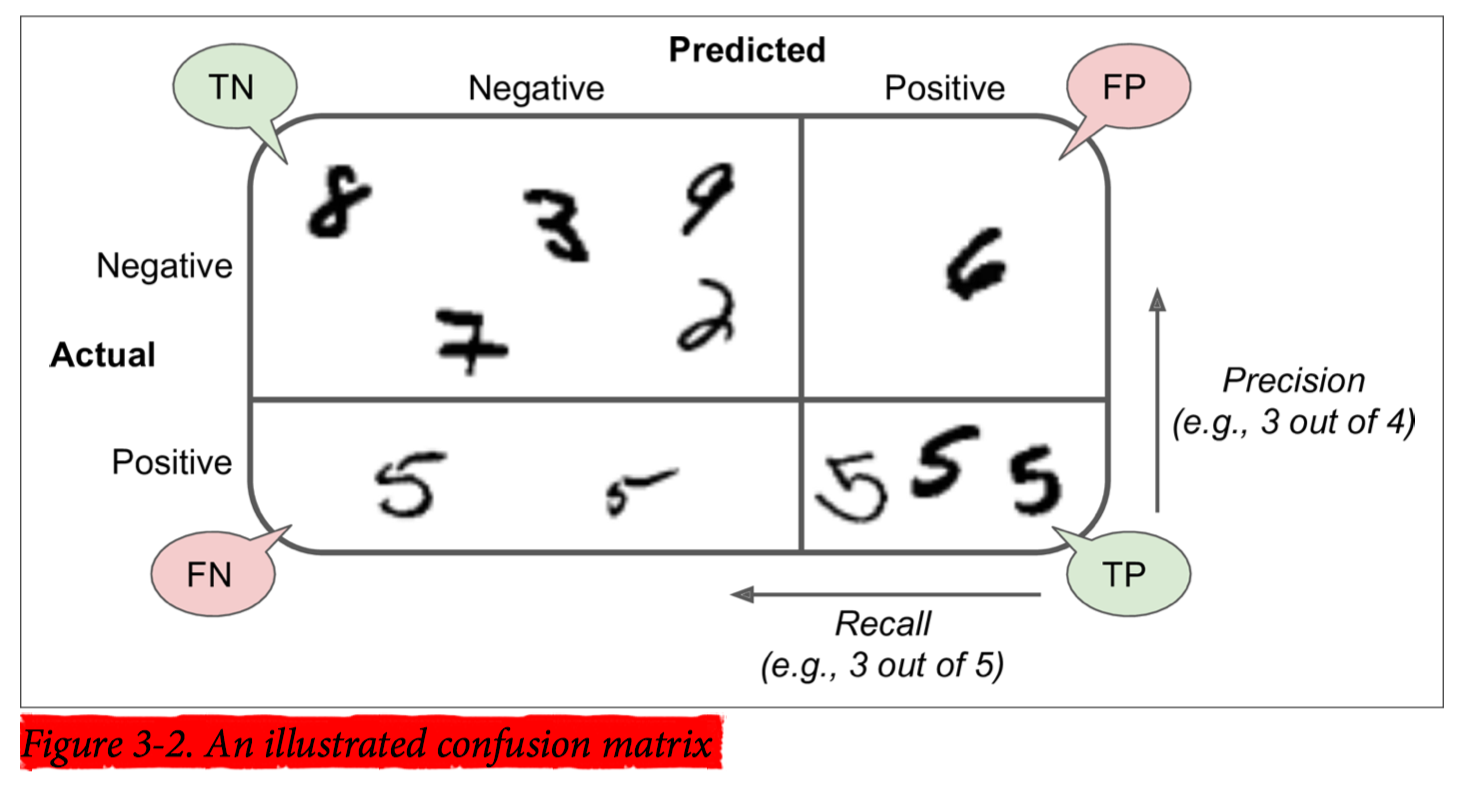

### 3.3.3 Precision and Recall
Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [14]:
sklearn.metrics.precision_score(y_train_5, y_train_pred)

0.76871350203503808

In [15]:
sklearn.metrics.recall_score(y_train_5, y_train_pred)

0.80132816823464303

Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 75% of the time. Moreover, it only detects 78% of the 5s.

It is often convenient to combine precision and recall into a single metric called the $F_1$ score, in particular if you need a simple way to compare two classifiers. The $F_1$ score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high $F_1$ score if both recall and precision are high:
- $F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = \frac{TP}{TP+\frac{FN+FP}{2}}$

To compute the $F_1$ score, simply call the `f1_score()` function:

In [16]:
sklearn.metrics.f1_score(y_train_5, y_train_pred)

0.78468208092485547

The $F_1$ score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. 

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the `precision/recall tradeoff`.


### 3.3.4 Precision/Recall Tradeoff
To understand this tradeoff, let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class. 

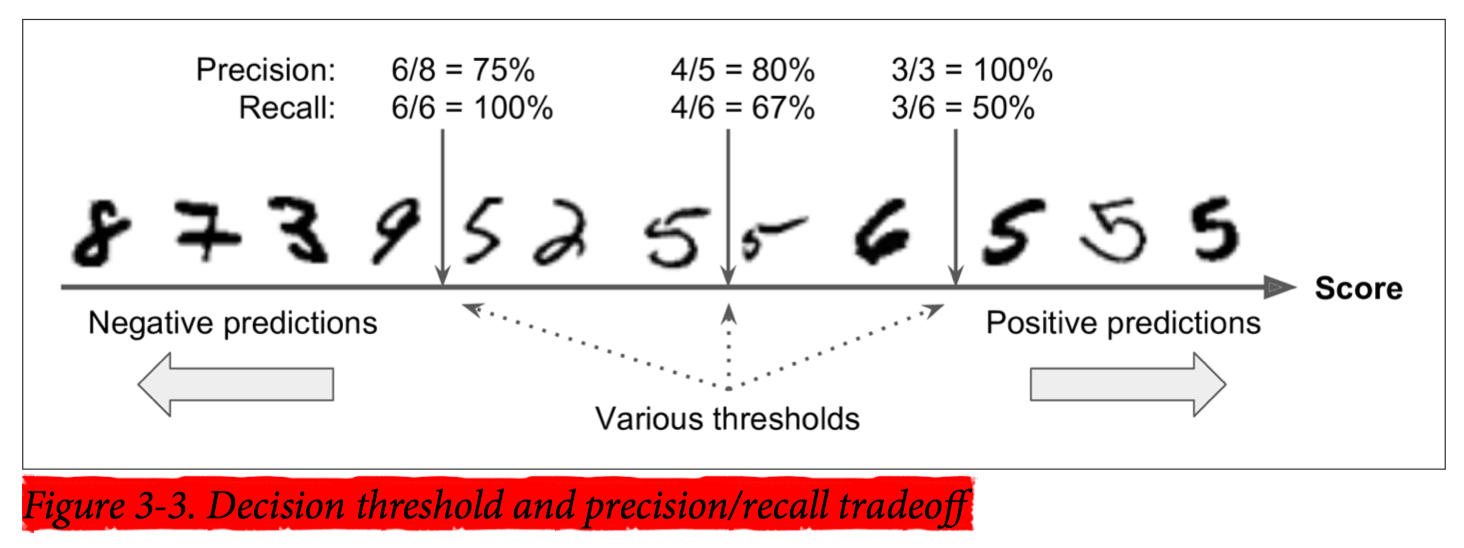

`Figure 3-3` shows a few digits positioned from the lowest score on the left to the highest score on the right. Suppose the decision threshold is positioned at the central arrow: you will find 4 true positives on the right of that threshold, and one false positive. Therefore, with that threshold, the precision is $80\%$, the recall is $67\%$. Now if you raise the threshold (move it to the arrow on the right), the false positive becomes a true negative, thereby increasing precision (up to $100\%$ in this case), but one true positive becomes a false negative, decreasing recall down to $50\%$. Conversely, lowering the threshold increases recall and reduces precision.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s `predict()` method, you can call its `decision_function()` method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want:

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 161855.74572176])

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [19]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 200,000.

So how can you decide which threshold to use? For this you will first need to get the scores of all instances in the training set using the `cross_val_predict()` function again, but this time specifying that you want it to return decision scores instead of predictions:

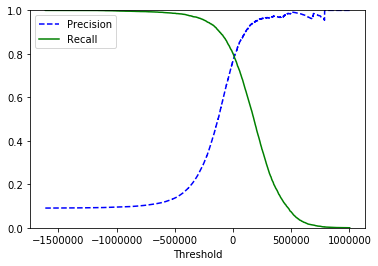

In [20]:
y_scores = sklearn.model_selection.cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                                                     method="decision_function")

# with these scores you can compute precision and recall for all possible thresholds 
# using the precision_recall_curve() function
precisions, recalls, thresholds = sklearn.metrics.precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlabel("Threshold") 
    plt.legend(loc="upper left") 
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds) 
plt.show()

> You may wonder why the precision curve is bumpier than the recall curve. The reason is that precision may sometimes go down when you raise the threshold (although in general it will go up). To understand why, look back at `Figure 3-3` and notice what happens when you start from the central threshold and move it just one digit to the right: precision goes from 4/5 (80%) down to 3/4 (75%). On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth.

Now you can simply select the threshold value that gives you the best precision/recall tradeoff for your task. Another way to select a good precision/recall tradeoff is to plot precision directly against recall, as shown in `Figure 3-5`:

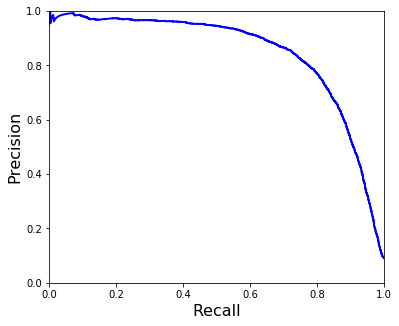

In [21]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(6, 5))
plot_precision_vs_recall(precisions, recalls)
plt.show()

You can see that precision really starts to fall sharply around $80\%$ recall. You will probably want to select a precision/recall tradeoff just before that drop—for example, at around $60\%$ recall. But of course the choice depends on your project.

So let’s suppose you decide to aim for $90\%$ precision. You look up the first plot and find that you need to use a threshold of about 50,000. To make predictions, instead of calling the classifier’s `predict()` method, you can just run this code:

In [22]:
y_train_pred_90 = (y_scores > 103500)
sklearn.metrics.precision_score(y_train_5, y_train_pred_90)

0.8997149520601192

In [23]:
sklearn.metrics.recall_score(y_train_5, y_train_pred_90)

0.64047223759453975

Great, you have a $90\%$ precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. Hmm, not so fast. A high-precision classifier is not very useful if its recall is too low! If someone says “let’s reach 99% precision,” you should ask, “at what recall?”


### 3.3.5 The ROC Curve
The `receiver operating characteristic` (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (tpr/recall) against the false positive rate (fpr):
- $TPR = \frac{TP}{TP+FN} = recall$
- $FPR = \frac{FP}{FP+TN} = 1-precision$

To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the roc_curve() function:

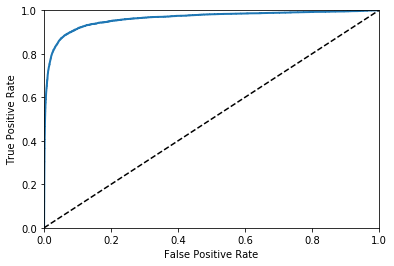

In [24]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr) 
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [25]:
sklearn.metrics.roc_auc_score(y_train_5, y_scores)

0.96244965559671547

> Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the topright corner).

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier. First, you need to get scores for each instance in the training set. The RandomForestClassifier class does not have a `decision_function()` method. Instead it has a `predict_proba()` method. Scikit-Learn classifiers generally have one or the other. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

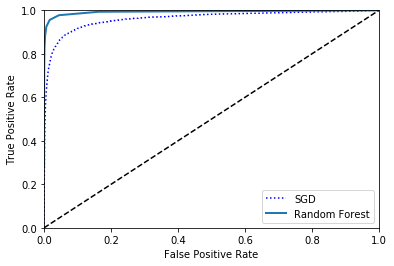

In [26]:
forest_clf = sklearn.ensemble.RandomForestClassifier(random_state=42) 
y_probas_forest = sklearn.model_selection.cross_val_predict(forest_clf, X_train, y_train_5, 
                                                            cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class 
fpr_forest, tpr_forest, thresholds_forest = sklearn.metrics.roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend(loc="lower right") 
plt.show()

As you can see, the RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better:

In [27]:
sklearn.metrics.roc_auc_score(y_train_5, y_scores_forest)

0.99312433660038291

***Now you know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/ recall tradeoff that fits your needs, and compare various models using ROC curves and ROC AUC scores***. 

Now let’s try to detect more than just the 5s.


## 3.4 Multiclass Classification
Multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as SVM classifiers or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

For example, one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the `one-versus-all` (OvA) strategy (also called `one-versus-the-rest`).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish `0` and `1`, another to distinguish `0` and `2`, another for `1` and `2`, and so on. This is called the `one-versus-one` (OvO) strategy. If there are $N$ classes, you need to train $N * \frac{N – 1}{2}$ classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as SVM classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO). Let’s try this with the SGDClassifier:

In [28]:
# y_train, not y_train_5
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

This code trains the SGDClassifier on the training set using the original target classes from 0 to 9, instead of the 5-versus-all target classes. Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

To see that this is indeed the case, you can call the decision_function() method. Instead of returning just one score per instance, it now returns 10 scores, one per class:

In [29]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [30]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [31]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

5.0

> When a classifier is trained, it stores the list of target classes in its `classes_` attribute, ordered by value. In this case, the index of each class in the `classes_` array conveniently matches the class itself (e.g., the class at index 5 happens to be class 5), but in general you won’t be so lucky.

If you want to force ScikitLearn to use `one-versus-one` or `one-versus-all`, you can use the `OneVsOneClassifier` or `OneVsRestClassifier`:

In [32]:
ovo_clf = sklearn.multiclass.OneVsOneClassifier(sklearn.linear_model.SGDClassifier(random_state=42, max_iter=5))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [33]:
len(ovo_clf.estimators_)

45

Training a RandomForestClassifier is just as easy:

In [34]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

Random Forest classifiers can directly classify instances into multiple classes. You can call `predict_proba()` to get the list of probabilities that the classifier assigned to each instance for each class:

In [35]:
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

The classifier is fairly confident about its prediction: the 0.8 at the 5 th index in the array means that the model estimates an $80\%$ probability that the image represents a `5`. It also thinks that the image could instead be a `0` or `3` ($10\%$ chance each).

Now of course you want to evaluate these classifiers. As usual, you want to use crossvalidation. Let’s evaluate the SGDClassifier’s accuracy using the `cross_val_score()` function:

In [36]:
sklearn.model_selection.cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.84063187,  0.84899245,  0.86652998])

It gets over $84\%$ on all test folds. If you used a random classifier, you would get $10\%$ accuracy, so this is not such a bad score, but you can still do much better. For example, simply scaling the inputs increases accuracy above $90\%$:

In [37]:
scaler = sklearn.preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
sklearn.model_selection.cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91011798,  0.90874544,  0.906636  ])

## 3.5 Error Analysis
Of course, if this were a real project, you would follow the steps in your Machine Learning project checklist (see Appendix B): exploring data preparation options, trying out multiple models, shortlisting the best ones and fine-tuning their hyperparameters using GridSearchCV, and automating as much as possible. Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First, you can look at the confusion matrix. You need to make predictions using the `cross_val_predict()` function, then call the `confusion_matrix()` function, just like you did earlier:

In [38]:
y_train_pred = sklearn.model_selection.cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = sklearn.metrics.confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s `matshow()` function:

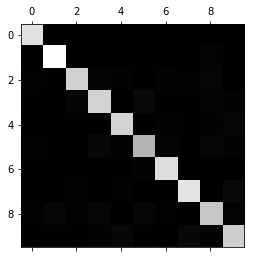

In [39]:
plt.matshow(conf_mx, cmap=plt.cm.gray) 
plt.show()

This confusion matrix looks fairly good, since most images are on the main diagonal, which means that they were classified correctly. The `5` look slightly darker than the other digits, which could mean that there are fewer images of `5` in the dataset or that the classifier does not perform as well on `5` as on other digits. In fact, you can verify that both are the case.

Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad):

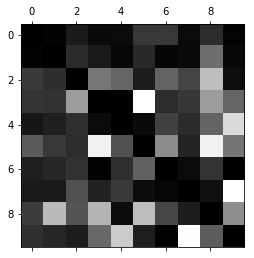

In [40]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Now you can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. The columns for classes `8` and `9` are quite bright, which tells you that many images get misclassified as `8` or `9`. Similarly, the rows for classes `8` and `9` are also quite bright, telling you that `8` and `9` are often confused with other digits. Conversely, some rows are pretty dark, such as row `1`: this means that most `1` are classified correctly (a few are confused with `8`, but that’s about it). Notice that the errors are not perfectly symmetrical; for example, there are more `5` misclassified as `8` than the reverse.

Analyzing the confusion matrix can often give you insights on ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on improving classification of `8` and `9`, as well as fixing the specific `3/5` confusion. For example, you could try to gather more training data for these digits. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming. For example, let’s plot examples of `3` and `5`:

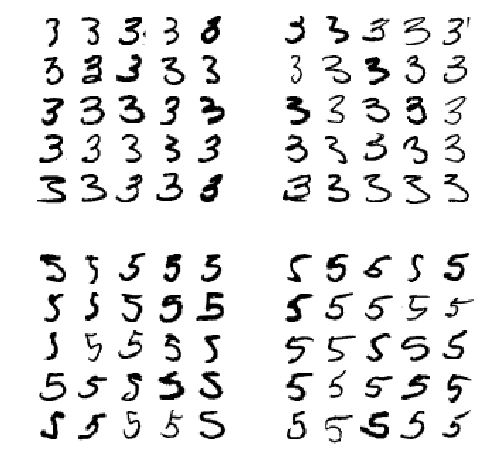

In [41]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5 
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] 
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] 
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] 
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two $5*5$ blocks on the left show digits classified as `3`, and the two $5*5$ blocks on the right show images classified as `5`. Some of the digits that the classifier gets wrong are so badly written that even a human would have trouble classifying them. However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did. The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since `3` and `5` differ only by a few pixels, this model will easily confuse them.

The main difference between `3` and `5` is the position of the small line that joins the top line to the bottom arc. If you draw a `3` with the junction slightly shifted to the left, the classifier might classify it as a `5`, and vice versa. In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the `3/5` confusion would be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well.



## 3.6 Multilabel Classification
Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. For example, consider a face-recognition classifier: what should it do if it recognizes several people on the same picture? Of course it should attach one label per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output `[1, 0, 1]` (meaning “Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple binary labels is called a multilabel classification system.

We won’t go into face recognition just yet, but let’s look at a simpler example, just for illustration purposes:

In [42]:
y_train_large = (y_train >= 7) 
y_train_odd = (y_train % 2 == 1) 
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = sklearn.neighbors.KNeighborsClassifier() 
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. For example, one approach is to measure the $F_1$ score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code computes the average $F_1$ score across all labels:

In [43]:
# too slowly!
# y_train_knn_pred = sklearn.model_selection.cross_val_predict(knn_clf, X_train, y_train, cv=3)
# sklearn.model_selection.f1_score(y_train, y_train_knn_pred, average="macro")

## 3.7 Multioutput Classification
The last type of classification task we are going to discuss here is called `multioutput multiclass classification` (or simply multioutput classification). It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system.

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities using NumPy’s randint() function. The target images will be the original images:

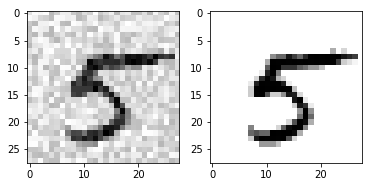

In [44]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation="nearest")
    # plt.axis("off")

some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

On the left is the noisy input image, and on the right is the clean target image. Now let’s train the classifier and make it clean this image:

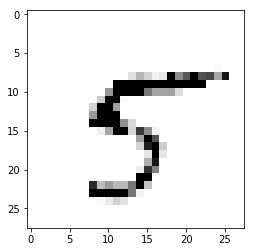

In [45]:
knn_clf.fit(X_train_mod, y_train_mod) 
clean_digit = knn_clf.predict([X_test_mod[some_index]]) 
plot_digit(clean_digit)
plt.show()

Looks close enough to the target! This concludes our tour of classification. Hopefully you should now know how to select good metrics for classification tasks, pick the appropriate precision/recall tradeoff, compare classifiers, and more generally build good classification systems for a variety of tasks.